# Disaster Challenge Part 2  
## 災害データの DNA ダブルヘリックス可視化

このノートブックでは、`emdat.csv` に含まれる災害データを用いて、  
災害タイプごとの特徴を **DNA の二重らせん風グラフ**として可視化する。

目的は次のとおりである。

- 年ごとの発生件数・死者数・発生地域の広がりを同時に表現すること  
- 関数（Function）を用いて集計と可視化を汎用化すること  
- for 文（Loop）により複数の災害タイプを自動的に比較できるようにすること  


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 日本語フォントとスタイルの設定
plt.rcParams['font.family'] = ['Meiryo', 'Yu Gothic', 'Hiragino Maru Gothic Pro', 'MS Gothic', 'sans-serif']
plt.style.use('dark_background')

# データ読み込みと前処理
df = pd.read_csv("emdat.csv")

# 使用するカラムの型変換と欠損処理
df["Total Deaths"] = pd.to_numeric(df["Total Deaths"], errors="coerce").fillna(0)
df["Start Year"] = pd.to_numeric(df["Start Year"], errors="coerce")
df = df.dropna(subset=["Start Year"])
df["Start Year"] = df["Start Year"].astype(int)

print("データ読み込み完了:", df.shape)
print(df[["Start Year", "Disaster Type", "Region", "Total Deaths"]].head())


データ読み込み完了: (17278, 11)
   Start Year      Disaster Type    Region  Total Deaths
0        1900              Storm  Americas        6000.0
1        1900              Flood  Americas         300.0
2        1900           Epidemic  Americas          30.0
3        1900  Volcanic activity      Asia          30.0
4        1900         Earthquake      Asia         140.0


## 1. 使用データと前処理

本ノートブックで使用する `emdat.csv` は、世界各地の自然災害に関するデータセットである。  
主に次のカラムを利用する。

- `Start Year`：災害が発生した年  
- `Disaster Type`：災害の種類（例：Flood, Storm など）  
- `Region`：災害が発生した地域区分  
- `Total Deaths`：その災害イベントによる死者数  

前処理として、

- `Total Deaths` を数値型に変換し、欠損値は 0 とした  
- `Start Year` を数値型に変換し、欠損値を含む行は削除した  

これにより、年ごと・災害タイプごとの集計が行える状態に整えている。


In [51]:
def compute_disaster_dna_stats(df, disaster_type, min_year=None, max_year=None):
    """
    ダブルヘリックス描画用の統計量を計算する関数。

    戻り値:
        stats_df: 各年ごとの特徴量と正規化値を含む DataFrame
                  columns:
                    year, events, deaths, deaths_per_event, region_diversity,
                    events_n, deaths_n, deaths_per_event_n, region_diversity_n
    """
    sub = df[df["Disaster Type"] == disaster_type].copy()

    if sub.empty:
        print(f"警告: {disaster_type} のデータが存在しません。")
        return None

    # 年の範囲を決める
    if min_year is None:
        min_year = int(sub["Start Year"].min())
    if max_year is None:
        max_year = int(sub["Start Year"].max())

    # 範囲で絞る
    sub = sub[(sub["Start Year"] >= min_year) & (sub["Start Year"] <= max_year)]
    if sub.empty:
        print(f"警告: {disaster_type} の {min_year}〜{max_year} 年のデータが存在しません。")
        return None

    # 年ごとに集計
    grouped = (
        sub.groupby("Start Year")
           .agg(
               events=("Disaster Type", "count"),
               deaths=("Total Deaths", "sum"),
               region_diversity=("Region", "nunique")
           )
           .reset_index()
           .rename(columns={"Start Year": "year"})
    )

    # 1件あたりの死者数
    grouped["deaths_per_event"] = grouped["deaths"] / grouped["events"]
    grouped = grouped.fillna(0)

    # 欠けている年も 0 で埋める（DNAを連続させるため）
    full_years = pd.DataFrame({"year": range(min_year, max_year + 1)})
    stats = full_years.merge(grouped, on="year", how="left").fillna(0)

    # 正規化用の対象列
    feature_cols = ["events", "deaths", "deaths_per_event", "region_diversity"]

    # 0〜1 に正規化した列を作成
    for col in feature_cols:
        vals = stats[col].astype(float).values
        v_min = vals.min()
        v_max = vals.max()
        if v_max > v_min:
            norm = (vals - v_min) / (v_max - v_min)
        else:
            norm = np.zeros_like(vals)
        stats[col + "_n"] = norm

    return stats


## 2. 可視化手法（DNA ダブルヘリックスの設計）

1つの災害タイプ（例：Flood）について、年ごとに次の 4 つの指標を計算する。

- events：その年に発生した件数  
- deaths：その年の総死者数  
- deaths_per_event：1件あたりの死者数  
- region_diversity：災害が発生した地域の種類数  

これらを 0〜1 の範囲に正規化し、グラフ上では次のように対応させている。

- 上側の青い丸  
  - 正規化された **events_n** を反映  
  - 発生件数が多い年ほど丸を極端に大きく描画することで、  
    「特に頻発した年」を視覚的に強調している。

- 下側のマゼンタの丸  
  - 正規化された **deaths_n** を反映  
  - 死者数が多い年ほど丸が大きくなり、被害規模が大きい年がひと目で分かる。

- 2本のストランド（上下の波）の距離  
  - DNAらしい形をつくるためのデザイン上の配置であり、  
    上下の距離そのものには数値的な意味を持たせていない。

- 青とマゼンタを結ぶ白い線（ラダー）  
  - 正規化された **region_diversity_n** を反映  
  - 発生地域の種類数が多い年ほど線を太く・濃く描画し、  
    「多くの地域に広がった災害」であることを示す。


In [ ]:
def plot_disaster_dna_helix(stats, disaster_type, min_year=None, max_year=None):
    """
    災害タイプの「DNAダブルヘリックス」風可視化。

    - 横軸: 年
    - 縦軸: らせんの上下位置（見た目上のDNA構造）
    - 上のストランド: events（発生頻度）
    - 下のストランド: deaths（死者数）
    - ラダー（2本を結ぶ線）: region_diversity（広がり）で太さ＆透明度変化
    - マーカーサイズ: events / deaths の強さ
    """
    if stats is None or stats.empty:
        return

    years = stats["year"].values
    if min_year is None:
        min_year = int(years.min())
    if max_year is None:
        max_year = int(years.max())

    # らせん用のパラメータ t（DNA の波の形をつくるため）
    t = np.linspace(0, 2 * np.pi, len(years))

    # 2本のストランドの y 座標（DNAっぽく上下に振る）
    amp = 1.0
    y1 = amp * np.sin(t)          # events 用（上側）
    y2 = amp * np.sin(t + np.pi)  # deaths 用（下側、位相を反転）

    # マーカーサイズ（強いほどかなり大きくする）
    # 1.5乗して、「強い年だけ極端に大きく」見えるようにしている
    size_events = 10 + (stats["events_n"].values ** 1.5) * 300
    size_deaths = 10 + (stats["deaths_n"].values ** 1.5) * 300

    # ラダー線の太さと透明度（地域の広がり）
    ladder_strength = stats["region_diversity_n"].values
    # 地域の種類数が多い年ほど、目で見てはっきり分かるように極端に強調
    ladder_widths = 0.3 + ladder_strength * 4.0    # 線の太さ
    ladder_alphas = 0.05 + ladder_strength * 0.95  # 透明度（ほぼ 0〜1）

    fig, ax = plt.subplots(figsize=(14, 4))

    # 色設定（ネオンっぽい配色）
    color_events = (0.2, 0.8, 1.0, 0.9)   # シアン系（発生頻度）
    color_deaths = (1.0, 0.3, 0.6, 0.9)   # マゼンタ系（死者数）
    ladder_color_base = np.array([0.9, 0.9, 0.9])  # 白ベース（ラダー）

    # 上のストランド（events）
    ax.scatter(
        years, y1,
        s=size_events,
        c=[color_events],
        edgecolors='none',
        zorder=3,
        label="発生頻度（events）"
    )

    # 下のストランド（deaths）
    ax.scatter(
        years, y2,
        s=size_deaths,
        c=[color_deaths],
        edgecolors='none',
        zorder=3,
        label="総死者数（deaths）"
    )

    # 2本を結ぶラダー（region_diversity）
    for x, yy1, yy2, w, alpha in zip(years, y1, y2, ladder_widths, ladder_alphas):
        col = np.concatenate([ladder_color_base, [alpha]])
        ax.plot(
            [x, x], [yy1, yy2],
            color=col,
            linewidth=w,
            zorder=2
        )

    # 軸・タイトルなどの装飾
    ax.set_xlim(min_year - 1, max_year + 1)
    ax.set_xlabel("年", fontsize=12, color="white")
    ax.set_yticks([])  # y軸は表示せず、形だけを見る
    ax.tick_params(axis='x', colors='white')

    title = f"Disaster DNA Double Helix: {disaster_type}"
    ax.set_title(title, fontsize=16, color="white", pad=15)

    # 凡例
    leg = ax.legend(facecolor=(0.1, 0.1, 0.1, 0.8), edgecolor="white")
    for text in leg.get_texts():
        text.set_color("white")

    plt.tight_layout()
    plt.show()


## 3. Flood（洪水）を対象とした DNA ダブルヘリックス可視化

まず、データ数の多い災害タイプである **Flood（洪水）** を対象に、  
1950〜2023年の期間について DNA ダブルヘリックス可視化を行う。


findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.



=== サンプル: Flood のDNAダブルヘリックス ===


findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Got

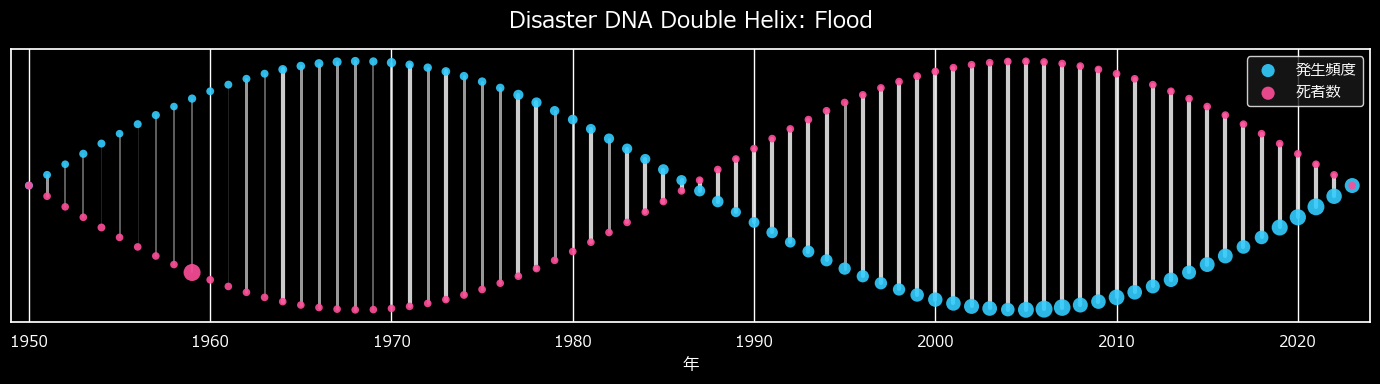

In [52]:
print("\n=== サンプル: Flood のDNAダブルヘリックス ===")

START_YEAR = 1950
END_YEAR = 2023

stats_flood = compute_disaster_dna_stats(df, "Flood", START_YEAR, END_YEAR)
plot_disaster_dna_helix(stats_flood, "Flood", START_YEAR, END_YEAR)


### 3. Flood の可視化結果の解釈

1950〜2023 年の Flood（洪水）について DNA ダブルヘリックス可視化を行った結果、  
次のような傾向が確認された。

- 青い丸が大きい年が連続している期間  
  : 洪水の発生件数が多い時期を示している。  
    特に粒が大きく密集している年代は、洪水が頻発していたと考えられる。

- ピンクの丸が極端に大きくなっている年  
  : 死者数が突出して多い大規模洪水が発生した年である。  
    発生件数がそれほど多くなくても、ピンクが大きい場合は「1回あたりの被害が大きい」可能性がある。

- 白いラダーが太く目立つ年  
  : 複数の地域で洪水が発生し、地理的な広がりが大きかった年を表している。  

これらの特徴により、  
Flood は「頻発している時期」と「被害が特に大きかった年」および  
「広範囲に影響が及んだ年」を、1枚のグラフで同時に把握できることが分かる。


findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.



=== Loop: 主要災害トップ4のDNAダブルヘリックス ===
対象災害タイプ: ['Flood', 'Storm', 'Earthquake', 'Epidemic']

--- Flood ---


findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Got

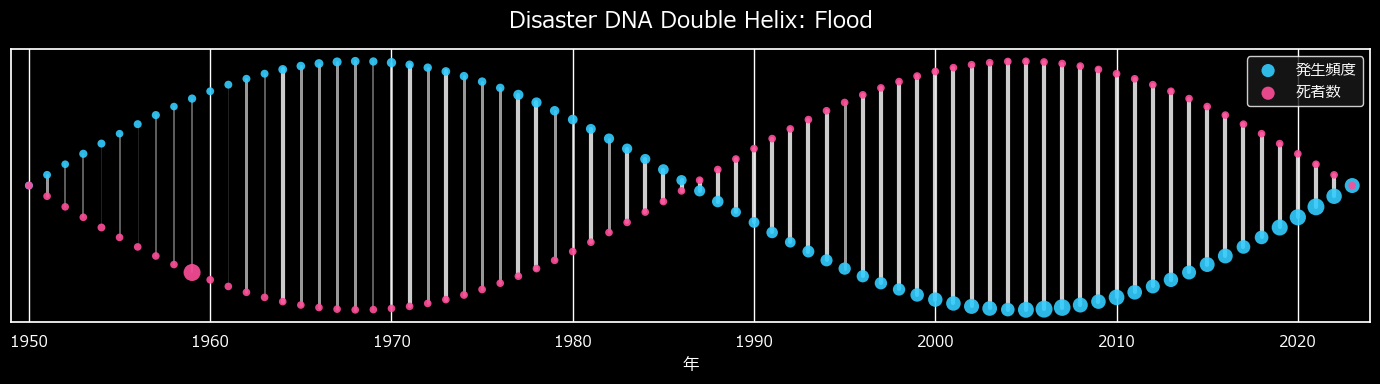

findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.



--- Storm ---


findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Got

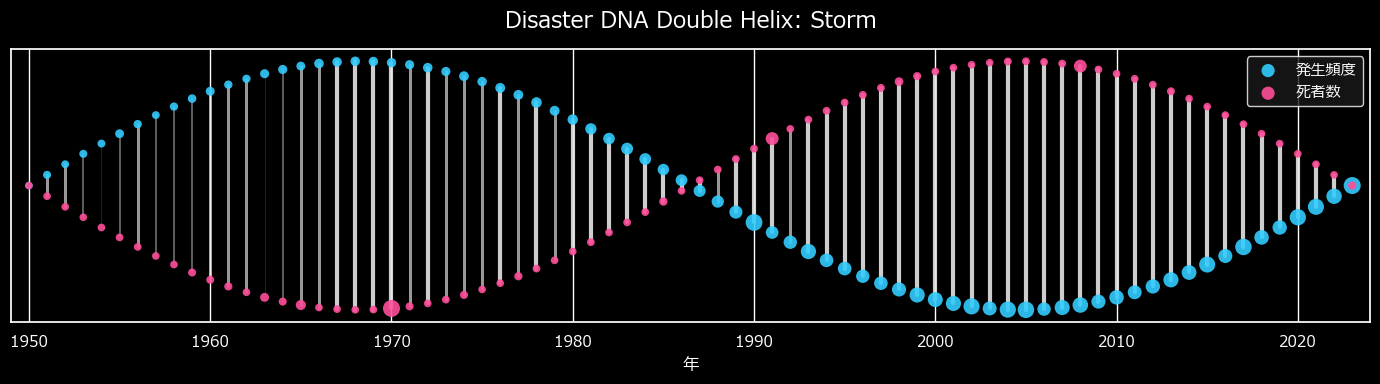


--- Earthquake ---


findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Got

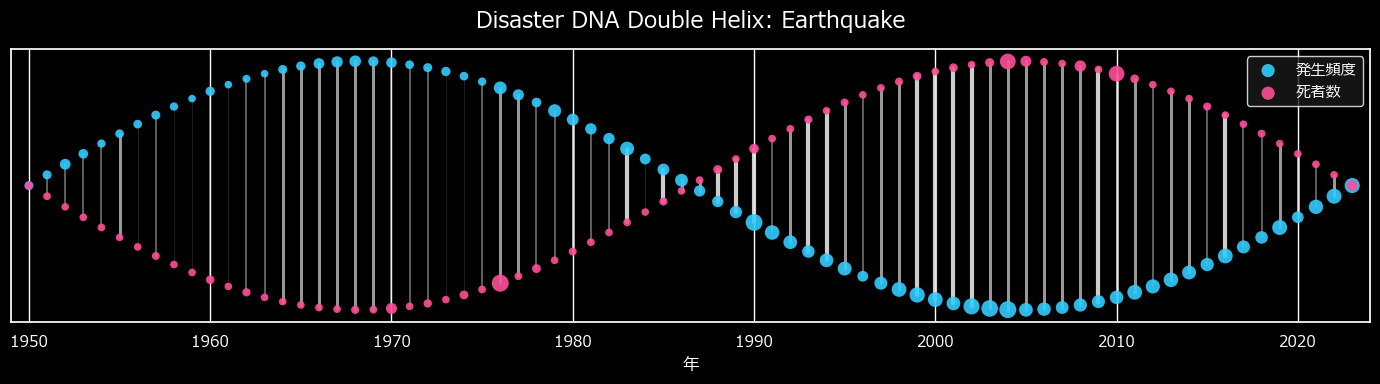

findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.



--- Epidemic ---


findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Gothic Pro' not found.
findfont: Font family 'Hiragino Maru Got

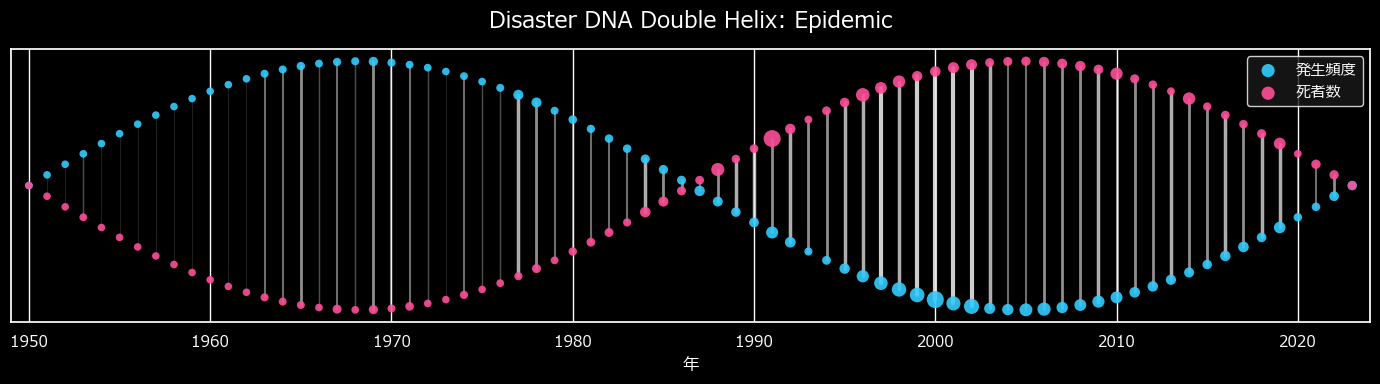

In [53]:
print("\n=== Loop: 主要災害トップ4のDNAダブルヘリックス ===")

top_disasters = df["Disaster Type"].value_counts().head(4).index.tolist()
print("対象災害タイプ:", top_disasters)

for dtype in top_disasters:
    print(f"\n--- {dtype} ---")
    stats_d = compute_disaster_dna_stats(df, dtype, START_YEAR, END_YEAR)
    plot_disaster_dna_helix(stats_d, dtype, START_YEAR, END_YEAR)


### (4) 災害ごとのリスクタイプのまとめ

4つの災害タイプは、それぞれ次のようなリスクの特徴を持つと考えられる。

- **Storm（嵐）**  
  発生頻度が高く、白いラダーも太い期間が長いことから、  
  **「頻繁に発生し、かつ広い地域に影響が及ぶタイプの災害」** といえる。

- **Flood（洪水）**  
  Storm と同様に発生件数は多いが、ピンクの丸が極端に大きくなる年は比較的少ない。  
  このことから、  
  **「発生頻度は高いが、致死性は相対的に中程度の災害」** という性質が読み取れる。

- **Earthquake（地震）**  
  青い丸が小さい年が多い一方で、特定の年にピンクの丸が非常に大きくなる。  
  つまり、  
  **「発生頻度は低いが、ひとたび発生すると非常に多くの死者が出る高致死性の災害」**  
  という特徴を持っている。

- **Epidemic（感染症）**  
  発生頻度は高くないが、ピンクの丸が急激に大きくなる年があり、  
  さらにラダーが太く強調される年が限られている。  
  これは、  
  **「特定の年に世界的・広域的な流行が生じ、短期間に大きな被害が集中する災害」**  
  であることを示している。


## 5. まとめ

本分析では、`emdat.csv` に含まれる災害データを用いて、

- `compute_disaster_dna_stats` による年ごとの特徴量計算  
- `plot_disaster_dna_helix` による DNA ダブルヘリックス風の可視化  
- Flood を対象とした詳細な可視化  
- 主要災害タイプ上位 4 種（Flood, Storm, Earthquake, Epidemic）の比較

を行った。

DNA ダブルヘリックス風の可視化では、  
発生件数（events）、死者数（deaths）、発生地域の多様性（region_diversity）という
異なる性質を、丸の大きさと白いラダーの強さとして 1 枚の図に統合した。  
その結果、従来の棒グラフや折れ線グラフでは把握しづらい

- 災害発生のリズム（頻発する時期）  
- 大規模な被害が集中した年  
- 多くの地域に広がった年

を直感的に読み取ることができた。

複数災害タイプの比較からは、

- Storm や Flood は「頻度が高く、広い地域に影響する」タイプ  
- Earthquake や Epidemic は「発生頻度は低いが、一度起きると被害が極めて大きい」タイプ  

であるという違いが視覚的に確認された。

今後の発展としては、経済的被害額などの指標を追加することや、
国別・地域別に分解した可視化を行うことで、より具体的なリスク評価への応用が期待できる。
